<a href="https://colab.research.google.com/github/mansivai/ArrayString/blob/master/TEXT_CLASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import nltk
import re

Load the traing data set

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data = pd.read_csv('/content/drive/MyDrive/ClauseClassification - ClauseClassification.csv' , names=["Traning set","class"], na_values=" NaN")
data.head()

,Traning set,class
0,The Borrower and certain lenders and agents ar...,Other
1,This CREDIT AGREEMENT is entered into as of No...,Preamble
2,This agreement is dated 22 December 2014 and m...,Preamble
3,This Agreement and shall be governed by and in...,Governing Law
4,The choice of South African law as the governi...,Governing Law


In [23]:
data=data.fillna('')

Remove stopwords

In [13]:
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_stopwords(x):
  x=word_tokenize(x)
  stopwords_all = stopwords.words('english')
  x = " ".join(i for i in x if not(i in stopwords_all))
  return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data["Traning set"] = data["Traning set"].apply(remove_stopwords)

In [19]:
def number_removal(row):
    data1 = row['Traning set']
    if type(data1) not in [int,float]:
        line = re.sub(r"[^A-Za-z\s]", " ", data1.strip())
        tokens = line.split()
    else:
        tokens=[]
    return ' '.join(tokens)
frequency_words_wo_stop = {}
def generate_word_frequency(row):
    data1 = row['Traning set']
    tokens = nltk.wordpunct_tokenize(data1)
    token_list = []
    for token in tokens:
        token_list.append(token.lower())
        if token.lower() in frequency_words_wo_stop:
            count = frequency_words_wo_stop[token.lower()]
            count = count + 1
            frequency_words_wo_stop[token.lower()] = count
        else:
            frequency_words_wo_stop[token.lower()] = 1
    return ','.join(token_list)


In [20]:
wordnet_lemmatizer = WordNetLemmatizer()

def receieve(query):
    data1=query
    data1['Traning set'] = data1.apply(number_removal,axis=1)
    data1['tokens'] = data1.apply(generate_word_frequency,axis=1)
    # print (data1.head())
    big=[]
    for i in data1['tokens']:
        st=''
        ls=[]
        for j in i.split(','):
            # print (wordnet_lemmatizer.lemmatize(j))
            ls.append(wordnet_lemmatizer.lemmatize(j))
        big.append(' '.join(ls))
    data1['Traning set_lem']=big
    return data1['Traning set_lem']
data['Traning set']=receieve(data[['Traning set']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Model Training

In [21]:
class_names=['Preamble','Governing Law','Lender Defaulting','Indemnification' , 'Other']

In [48]:
data = data.sample(frac=1, random_state=15).reset_index(drop=True)

In [49]:
arr=data['Traning set'].tolist()
arr_lbl = data['class'].tolist()

In [50]:
train_arr = arr[:23]
test_arr = arr[23:]
train_lbl  = arr_lbl[:23]
test_lbl  = arr_lbl[23:]

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [52]:
vectorizer = CountVectorizer()
vectorizer.fit(train_arr)
train_mat = vectorizer.transform(train_arr)
print (train_mat.shape)
test_mat = vectorizer.transform(test_arr)
print (test_mat.shape)

(23, 242)
(4, 242)


In [53]:
tfidf = TfidfTransformer()
tfidf.fit(train_mat)
train_tfmat = tfidf.transform(train_mat)
print (train_tfmat.shape)
test_tfmat = tfidf.transform(test_mat)
print (test_tfmat.shape)

(23, 242)
(4, 242)


In [54]:
del train_arr

In [55]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from pprint import pprint
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

#Naive Bayes 

Bernoulli Nave Bayes


In [57]:
bnb= BernoulliNB()
#fitting
bnb.fit(train_tfmat, train_lbl)
#ypred
ypredBnb = bnb.predict(test_tfmat)
print ('Bernoulli accuracy score')
print (accuracy_score(test_lbl, ypredBnb))

Bernoulli accuracy score
0.5


[[0 1 0 1 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]


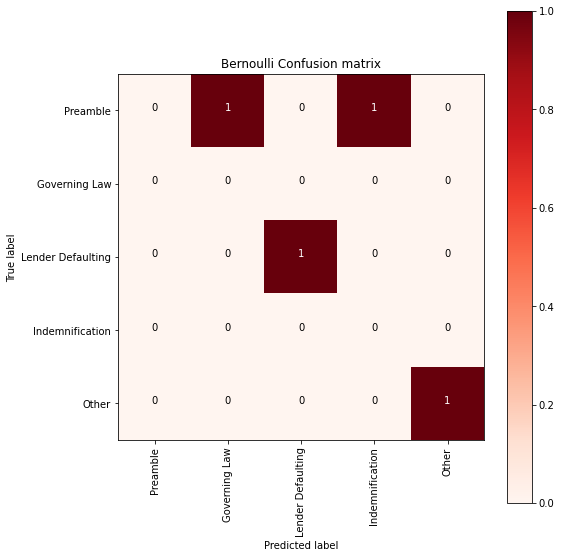

In [58]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredBnb), classes=class_names,  title='Bernoulli Confusion matrix')
plt.show()

Multinomial Naive Bayes


In [59]:
mnb=MultinomialNB()
#fitting
mnb.fit(train_tfmat, train_lbl)
ypredMnb = mnb.predict(test_tfmat)
print ('Multinomial accuracy score')
print (accuracy_score(test_lbl, ypredMnb))

Multinomial accuracy score
0.5


[[0 1 0 1 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]


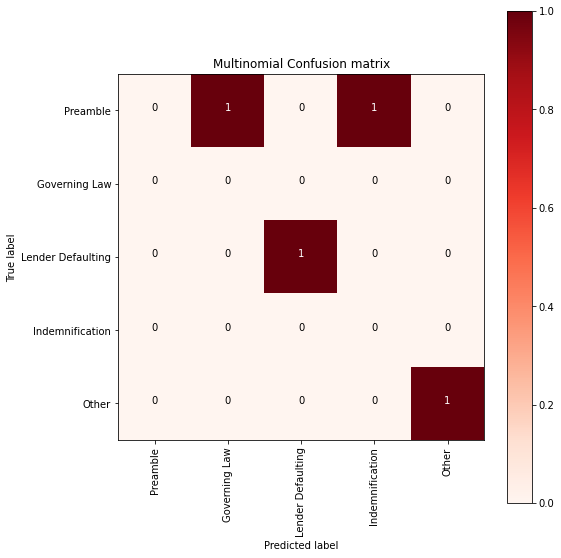

In [60]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredMnb), classes=class_names,
                      title='Multinomial Confusion matrix')

plt.show()

#SVM

In [61]:
from sklearn.svm import LinearSVC, NuSVC, SVC

Linear SVC

In [62]:
lsvm= LinearSVC()
#fitting
lsvm.fit(train_tfmat, train_lbl)
#ypred
ypredLsvm = lsvm.predict(test_tfmat)

In [63]:
print ('Linear Svm accuracy score')
print (accuracy_score(test_lbl, ypredLsvm))

Linear Svm accuracy score
1.0


[[2 0 0]
 [0 1 0]
 [0 0 1]]


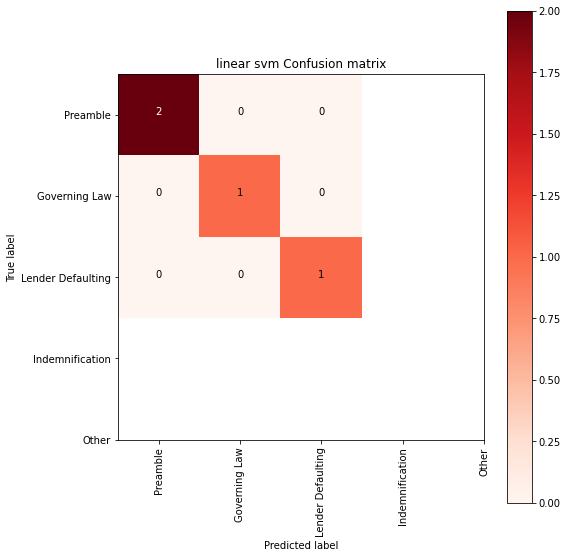

In [64]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredLsvm), classes=class_names,
                      title='linear svm Confusion matrix')

plt.show()

Non linear svm

In [65]:
nusvm=NuSVC()
#fitting
nusvm.fit(train_tfmat, train_lbl)
#ypred
ypredNusvm = nusvm.predict(test_tfmat)
print ('Non Linear svm accuracy score')
print (accuracy_score(test_lbl, ypredNusvm))

Non Linear svm accuracy score
0.75


[[1 0 1 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 1]]


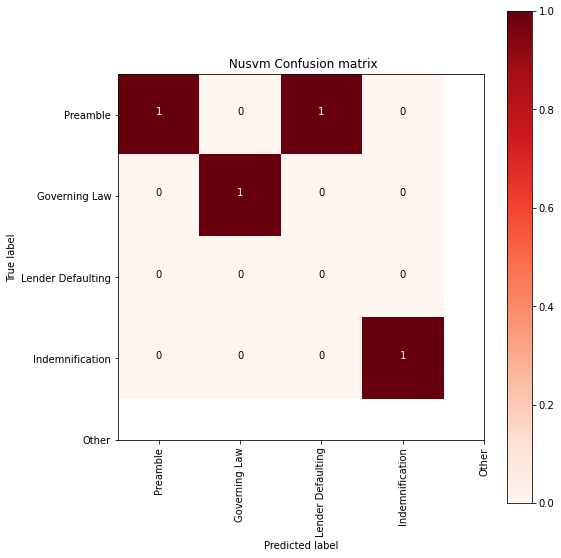

In [66]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredNusvm), classes=class_names,
                      title=' Nusvm Confusion matrix')

plt.show()

#KNN

In [67]:
from sklearn.neighbors import KNeighborsClassifier

Uniform KNN

In [68]:
knn_uni = KNeighborsClassifier(n_neighbors=5, weights = 'uniform')
#fitting
knn_uni.fit(train_tfmat, train_lbl)
#ypred
ypred_knn_uni = knn_uni.predict(test_tfmat)
print ('Distant accuracy score')
print (accuracy_score(test_lbl, ypred_knn_uni))

Distant accuracy score
1.0


[[2 0 0]
 [0 1 0]
 [0 0 1]]


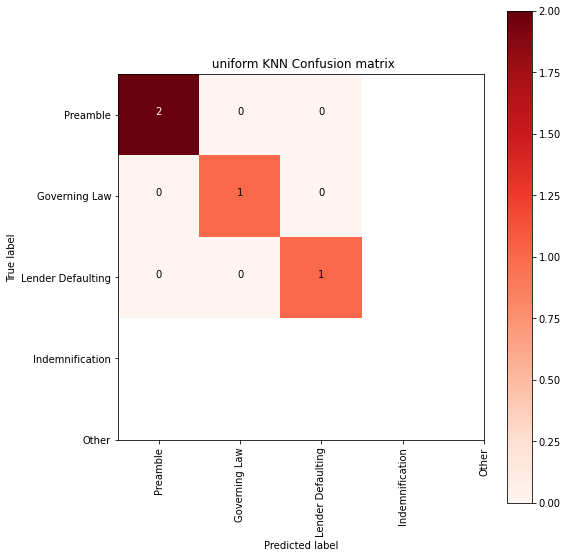

In [69]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypred_knn_uni), classes=class_names,
                      title=' uniform KNN Confusion matrix')

plt.show()

Distinct KNN

In [70]:
knn_dist = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
#fitting
knn_dist.fit(train_tfmat, train_lbl)
#ypred
ypred_knn_dist = knn_dist.predict(test_tfmat)
print ('Distant accuracy score')
print (accuracy_score(test_lbl, ypred_knn_dist))

Distant accuracy score
1.0


[[2 0 0]
 [0 1 0]
 [0 0 1]]


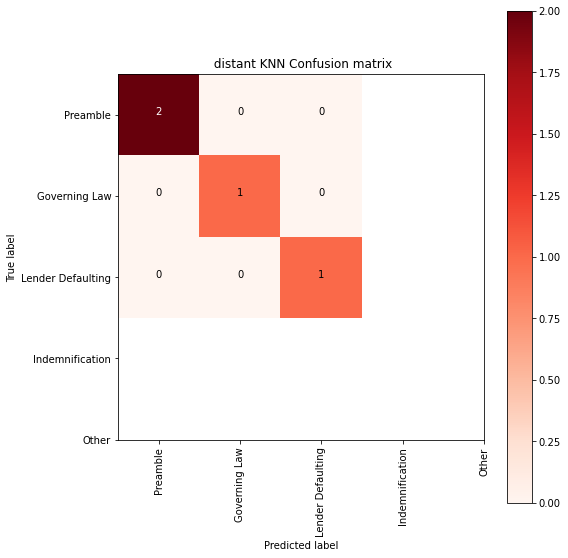

In [71]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypred_knn_dist), classes=class_names,  title=' distant KNN Confusion matrix')

plt.show()